## GLENS analysis - Extremes Paper

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import nc_time_axis
import cf_xarray 
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import cartopy
import regionmask

### Define file paths

In [2]:
ctrl_lnd_path = '/glade/scratch/kdagon/GLENS/control/lnd/'
fdbk_lnd_path = '/glade/scratch/kdagon/GLENS/feedback/lnd/'
ctrl_atm_path = '/glade/scratch/kdagon/GLENS/control/atm/'
fdbk_atm_path = '/glade/scratch/kdagon/GLENS/feedback/atm/'

### Write a function to read in given variable for two simulations-time periods

In [3]:
def read_var_sims(var):
    
    # variable file paths
    ctrl_lnd_path_var = ctrl_lnd_path+var+'/'
    fdbk_land_path_var = fdbk_lnd_path+var+'/'
    
    # number of ensemble members - maybe make this an input to the function?
    nens = 20
    
    # define ensemble member dim
    ensdim = xr.DataArray(np.array(range(nens)), dims='ens', name='ens')
    dims = [ensdim,'time']
    
    # create file lists
    ctrl_lnd_files = [ctrl_lnd_path_var+'*'+str(e+1).zfill(3)+'*'+var+'*.nc' for e in range(nens)]
    fdbk_lnd_files = [fdbk_land_path_var+'*'+str(e+1).zfill(3)+'*'+var+'*.nc' for e in range(nens)]
    
    # set ctrl years - maybe make this function input?
    # these variables are needed for preprocess function (not sure how to pass additional arguments)
    firstyear=2010
    lastyear=2030
    
    # need to define preprocess inside this function to update variable name
    def preprocess(ds):
        attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
        time_bounds = ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
        time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
        ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
        ds.time.attrs, ds.time.encoding = attrs, encoding
        return ds[var].sel(time=slice(str(firstyear), str(lastyear)))
    
    # read one file string at a time, then concat over ensemble members
    dsets=[]
    for ffs in ctrl_lnd_files:
        df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
        dsets.append(df)
    ctrl_lnd_var = xr.concat(dsets,dim=ensdim)
    
    # reset years
    firstyear=2075
    lastyear=2095
    
    # feedback files
    dsets=[]
    for ffs in fdbk_lnd_files:
        df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
        dsets.append(df)
    fdbk_lnd_var = xr.concat(dsets,dim=ensdim)

    return(ctrl_lnd_var, fdbk_lnd_var)

### Write a function to calculation ensemble mean, annual mean differences

In [4]:
diffname = 'Feedback (2075-2095) minus Control (2010-2030)'

In [5]:
def calc_sim_diffs(var):
    var_das = read_var_sims(var)
    var_diff = var_das[1].mean(('time','ens')) - var_das[0].mean(('time','ens')) # feedback - control
    return(var_diff)

### Panel plot with LHF and SM10

In [7]:
LH_diffs = calc_sim_diffs('EFLX_LH_TOT').persist()

In [8]:
SM10_diffs = calc_sim_diffs('SOILWATER_10CM').persist()

Checking min/max values for plot

In [8]:
LH_diffs.max().values

array(8.479923, dtype=float32)

In [9]:
LH_diffs.min().values

array(-11.983467, dtype=float32)

In [10]:
SM10_diffs.max().values

array(19.028194, dtype=float32)

In [11]:
SM10_diffs.min().values

array(-33.251675, dtype=float32)

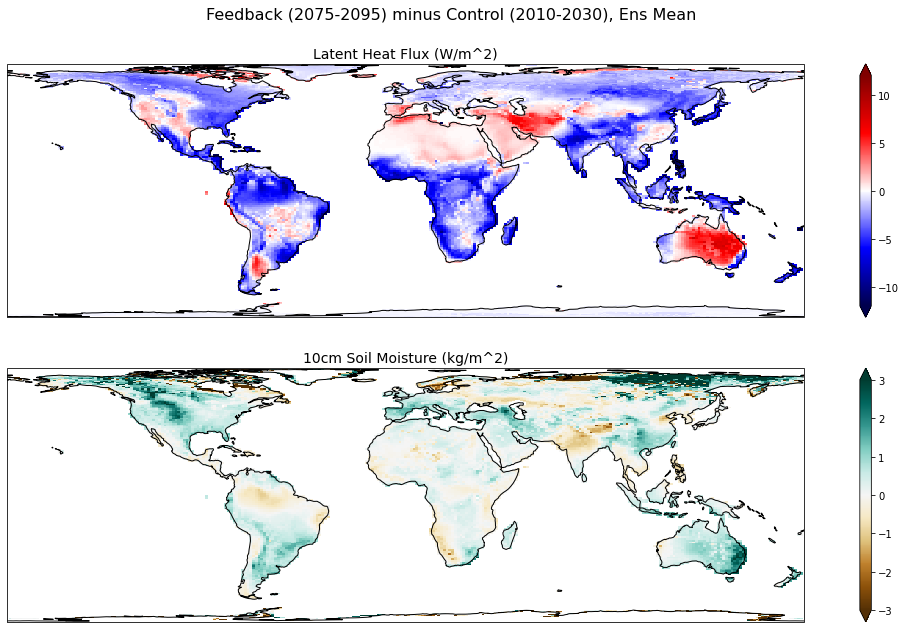

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})

# discrete colormap
#cmap=plt.cm.get_cmap('BrBG', 14)

field, lon = add_cyclic_point(LH_diffs, coord=LH_diffs.lon)
lat = LH_diffs.lat   
cf = axs[0].pcolormesh(lon, lat, field, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-12, vmax=12)
#cf = axs[0].contourf(lon, lat, field, levels=24, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-12, vmax=12, extend='both')
axs[0].coastlines()
axs[0].set_global()  
axs[0].set_title('Latent Heat Flux (W/m^2)', fontsize=14)
fig.colorbar(cf, ax=axs[0], orientation='vertical', extend='both')

field, lon = add_cyclic_point(SM10_diffs, coord=SM10_diffs.lon)
lat = SM10_diffs.lat   
cf = axs[1].pcolormesh(lon, lat, field, cmap='BrBG',transform=ccrs.PlateCarree(), vmin=-3, vmax=3)
axs[1].coastlines()
axs[1].set_global()
axs[1].set_title('10cm Soil Moisture (kg/m^2)', fontsize=14)
fig.colorbar(cf, ax=axs[1], orientation='vertical', extend='both')

fig.suptitle(diffname+', Ens Mean', fontsize=16)

# Adjust the location of the subplots on the page to make room for the colorbar
#fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.2)
fig.subplots_adjust(top=0.9, hspace=0.2)

# Colorbar settings - coordinate left and width to be centered
#cb_ax = fig.add_axes([0.4, 0.15, 0.2, 0.02])
#cmap = mpl.cm.seismic
#norm = mpl.colors.Normalize(vmin=-5, vmax=5)
#cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')
#cb1.ax.set_xlabel('10cm Soil Moisture (kg/m^2)', fontsize=14);

#plt.savefig("LHF_SM10_diffs.png")

TO DO: Add PRECTMX as a third panel? Or whatever is used to generate Rx1day?\
Or keep the two panels but zoom in on India to compare to Mari\
And/or figure out what's driving the decrease in LHF over India (qflux breakdown) and decrease in SM10 over India (soil changes w/ depth?)

### Adding LAI diffs

In [6]:
TLAI_diffs = calc_sim_diffs('TLAI').persist()

In [52]:
TLAI_diffs.max().values

array(5.042156, dtype=float32)

In [53]:
TLAI_diffs.min().values

array(-2.0214605, dtype=float32)

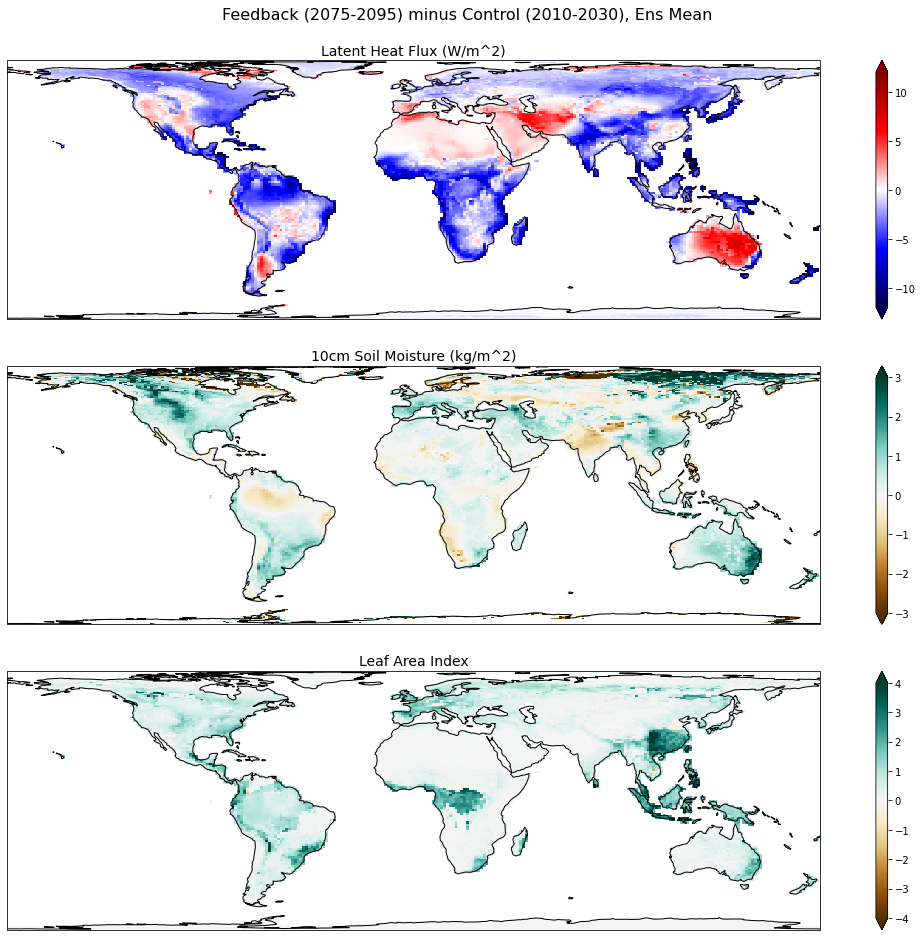

In [68]:
fig, axs = plt.subplots(3, 1, figsize=(20, 15), subplot_kw={'projection': ccrs.LambertCylindrical()})

# discrete colormap
#cmap=plt.cm.get_cmap('BrBG', 14)

field, lon = add_cyclic_point(LH_diffs, coord=LH_diffs.lon)
lat = LH_diffs.lat   
cf = axs[0].pcolormesh(lon, lat, field, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-12, vmax=12)
#cf = axs[0].contourf(lon, lat, field, levels=24, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-12, vmax=12, extend='both')
axs[0].coastlines()
axs[0].set_global()  
axs[0].set_title('Latent Heat Flux (W/m^2)', fontsize=14)
fig.colorbar(cf, ax=axs[0], orientation='vertical', extend='both')

field, lon = add_cyclic_point(SM10_diffs, coord=SM10_diffs.lon)
lat = SM10_diffs.lat   
cf = axs[1].pcolormesh(lon, lat, field, cmap='BrBG',transform=ccrs.PlateCarree(), vmin=-3, vmax=3)
axs[1].coastlines()
axs[1].set_global()
axs[1].set_title('10cm Soil Moisture (kg/m^2)', fontsize=14)
fig.colorbar(cf, ax=axs[1], orientation='vertical', extend='both')

field, lon = add_cyclic_point(TLAI_diffs, coord=TLAI_diffs.lon)
lat = TLAI_diffs.lat   
cf = axs[2].pcolormesh(lon, lat, field, cmap='BrBG',transform=ccrs.PlateCarree(), vmin=-4, vmax=4)
axs[2].coastlines()
axs[2].set_global()
axs[2].set_title('Leaf Area Index', fontsize=14)
fig.colorbar(cf, ax=axs[2], orientation='vertical', extend='both')

fig.suptitle(diffname+', Ens Mean', fontsize=16)

# Adjust the location of the subplots on the page to make room for the colorbar
#fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.2)
fig.subplots_adjust(top=0.93, hspace=0.18)

# Colorbar settings - coordinate left and width to be centered
#cb_ax = fig.add_axes([0.4, 0.15, 0.2, 0.02])
#cmap = mpl.cm.seismic
#norm = mpl.colors.Normalize(vmin=-5, vmax=5)
#cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')
#cb1.ax.set_xlabel('10cm Soil Moisture (kg/m^2)', fontsize=14);

#plt.savefig("LHF_SM10_TLAI_diffs.png")

### Adding GPP diffs

In [9]:
GPP_diffs = calc_sim_diffs('GPP').persist()

In [12]:
GPP_diffs.max().values*86400*365 # convert gC/m2/s to gC/m2/yr

1428.9170445408672

In [13]:
GPP_diffs.min().values*86400*365

-931.6431516199373

### Revise the above figure to match other extremes figures

In [15]:
# testing out regions
regions = ["NSA", "NES", "WAF", "CAF", "SAS"]
ar6 = regionmask.defined_regions.ar6.land
ar6[regions]

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


<regionmask.Regions>
Name:     AR6 reference regions (land only)
Source:   Iturbide et al., 2020 (Earth Syst. Sci. Data)

Regions:
10 NSA   N.South-America
11 NES N.E.South-America
21 WAF    Western-Africa
22 CAF    Central-Africa
37 SAS            S.Asia

[5 regions]

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/regionmask/core/plot.py:151: FutureWarning: 'proj' has been renamed to 'projection'
  warnings.warn("'proj' has been renamed to 'projection'", FutureWarning)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/regionmask/core/plot.py:12: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  coords += [np.asarray(p.exterior)[:, :2]] + [
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geome

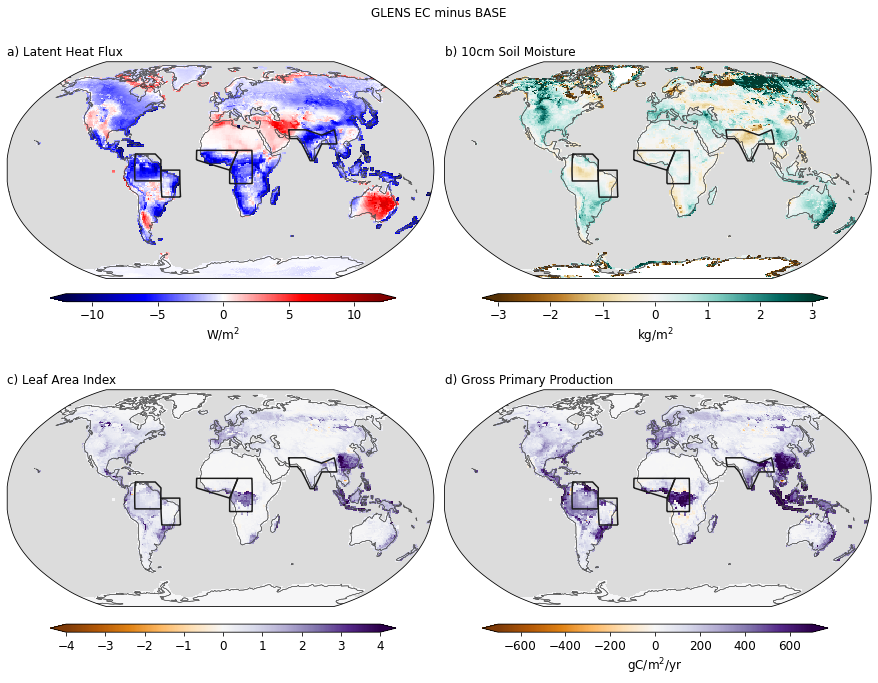

In [21]:
# LHF range
min_a=-12; max_a=12
# SM10 range
min_b=-3; max_b=3
# TLAI range
min_c=-4; max_c=4
# GPP range (gC/m2/yr)
min_d=-700; max_d=700

# LHF colormap
cmap_a = plt.cm.seismic
# SM10 colormap
cmap_b = plt.cm.BrBG
# TLAI colormap
cmap_c = plt.cm.PuOr
# GPP colormap
cmap_d = plt.cm.PuOr

# define ar6 regions
regions = ["NSA", "NES", "WAF", "CAF", "SAS"]
ar6 = regionmask.defined_regions.ar6.land

fig = plt.figure(figsize=(12, 9))

grid = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, left=0., right=1., top=1., bottom=0.,
                         wspace=0.025, hspace=0.025,)

proj = ccrs.PlateCarree()

ax1 = fig.add_subplot(grid[0], projection=ccrs.Robinson())
ax2 = fig.add_subplot(grid[1], projection=ccrs.Robinson())
ax3 = fig.add_subplot(grid[2], projection=ccrs.Robinson())
ax4 = fig.add_subplot(grid[3], projection=ccrs.Robinson())

# add greyed out ocean
ax1.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax2.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax3.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax4.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

# add coastlines
ax1.coastlines(linewidth=0.5, zorder=1)
ax2.coastlines(linewidth=0.5, zorder=1)
ax3.coastlines(linewidth=0.5, zorder=1)
ax4.coastlines(linewidth=0.5, zorder=1)

# add regional boxes
ar6[regions].plot(ax=ax1, proj=proj, add_label=False)
ar6[regions].plot(ax=ax2, proj=proj, add_label=False)
ar6[regions].plot(ax=ax3, proj=proj, add_label=False)
ar6[regions].plot(ax=ax4, proj=proj, add_label=False)

# -------- plots

# LHF
field, lon = add_cyclic_point(LH_diffs, coord=LH_diffs.lon)
lat = LH_diffs.lat
pl_a = ax1.pcolormesh(lon, lat, field, cmap=cmap_a, vmin=min_a, vmax=max_a, transform=proj)
ax1.set_title('a) Latent Heat Flux', fontsize=12, loc='left')

# SM10
field, lon = add_cyclic_point(SM10_diffs, coord=SM10_diffs.lon)
lat = SM10_diffs.lat 
pl_b = ax2.pcolormesh(lon, lat, field, cmap=cmap_b, vmin=min_b, vmax=max_b, transform=proj)
ax2.set_title('b) 10cm Soil Moisture', fontsize=12, loc='left')

# TLAI
field, lon = add_cyclic_point(TLAI_diffs, coord=TLAI_diffs.lon)
lat = TLAI_diffs.lat 
pl_c = ax3.pcolormesh(lon, lat, field, cmap=cmap_c, vmin=min_c, vmax=max_c, transform=proj)
ax3.set_title('c) Leaf Area Index', fontsize=12, loc='left')

# GPP
field, lon = add_cyclic_point(GPP_diffs*86400*365, coord=GPP_diffs.lon) # convert gC/m2/s to gC/m2/yr
lat = GPP_diffs.lat 
pl_d = ax4.pcolormesh(lon, lat, field, cmap=cmap_d, vmin=min_d, vmax=max_d, transform=proj)
ax4.set_title('d) Gross Primary Production', fontsize=12, loc='left')

# ----------- colorbars

cax = fig.add_axes([0.05, 0.55, 0.4, 0.0125])
cbar_ = plt.colorbar(pl_a, orientation='horizontal', cax=cax, extend='both')
cbar_.set_label(label = 'W/m$^2$', size=12)
#cbar_.set_ticks([-300,-200,-100,0,100,200,300])
cbar_.ax.tick_params(labelsize=12)

cax = fig.add_axes([0.55, 0.55, 0.4, 0.0125])
cbar_ = plt.colorbar(pl_b, orientation='horizontal', cax=cax, extend='both')
cbar_.set_label(label = 'kg/m$^2$', size=12)
#cbar_.set_ticks([-1.5,-1.0,-0.5,0,0.5,1.0,1.5,2.0])
cbar_.ax.tick_params(labelsize=12)

cax = fig.add_axes([0.05, 0.04, 0.4, 0.0125])
cbar_ = plt.colorbar(pl_c, orientation='horizontal', cax=cax, extend='both')
#cbar_.set_label(label = 'mm', size=12)
#cbar_.set_ticks([-20,-15,-10,-5,0,5,10,15,20])
cbar_.ax.tick_params(labelsize=12)

cax = fig.add_axes([0.55, 0.04, 0.4, 0.0125])
cbar_ = plt.colorbar(pl_d, orientation='horizontal', cax=cax, extend='both')
cbar_.set_label(label = 'gC/m$^2$/yr', size=12)
#cbar_.set_ticks([-20,-15,-10,-5,0,5,10,15,20])
cbar_.ax.tick_params(labelsize=12)

# ----------- map gridlines
"""
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, lw=0.75, color='gray', alpha=0.5, ls='--')
gl.xlocator = mticker.FixedLocator([-90, 0, 90]); gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60]); gl.ylabel_style = {'size': 10, 'color': 'gray'}
gl.top_labels = False; gl.left_labels = False; gl.bottom_labels = False; gl.right_labels = False

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, lw=0.75, color='gray', alpha=0.5, ls='--')
gl.xlocator = mticker.FixedLocator([-90, 0, 90]); gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60]); gl.ylabel_style = {'size': 10, 'color': 'gray'}
gl.top_labels = False; gl.left_labels = False; gl.bottom_labels = False; gl.right_labels = False

gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, lw=0.75, color='gray', alpha=0.5, ls='--')
gl.xlocator = mticker.FixedLocator([-90, 0, 90]); gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60]); gl.ylabel_style = {'size': 10, 'color': 'gray'}
gl.top_labels = False; gl.left_labels = False; gl.bottom_labels = False; gl.right_labels = False

gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, lw=0.75, color='gray', alpha=0.5, ls='--')
gl.xlocator = mticker.FixedLocator([-90, 0, 90]); gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60]); gl.ylabel_style = {'size': 10, 'color': 'gray'}
gl.top_labels = False; gl.left_labels = False; gl.bottom_labels = False; gl.right_labels = False
"""
# ----------- titles

fig.suptitle("GLENS EC minus BASE", fontsize=12, y=1.005);

# geocat way of setting subplot titles (would need to import/change environment)
#gvutil.set_titles_and_labels(ax1, lefttitle="a) Latent Heat Flux", lefttitlefontsize=12)
#gvutil.set_titles_and_labels(ax2, lefttitle="b) 10cm Soil Moisture", lefttitlefontsize=12)
#gvutil.set_titles_and_labels(ax3, lefttitle="c) Leaf Area Index", lefttitlefontsize=12)
#gvutil.set_titles_and_labels(ax4, lefttitle="d) Gross Primary Production", lefttitlefontsize=12)

# ----------- save fig

#plt.savefig('../figures/LHF_SM10_TLAI_GPP_diffs.png', bbox_inches='tight')
#plt.savefig('../figures/LHF_SM10_TLAI_GPP_diffs_greyocn.png', bbox_inches='tight')
plt.savefig('../figures/LHF_SM10_TLAI_GPP_diffs_greyocn_regions.png', bbox_inches='tight')
plt.show()
plt.close()

# -------- 

### QFLX breakdown

In [22]:
QSOIL_diffs = calc_sim_diffs('QSOIL').persist()

In [76]:
QSOIL_diffs.max().values*86400*365 # convert from mm/s to mm/yr

152.5007324598846

In [77]:
QSOIL_diffs.min().values*86400*356

-273.68582440540195

In [23]:
QVEGE_diffs = calc_sim_diffs('QVEGE').persist()

In [78]:
QVEGE_diffs.max().values*86400*365

110.30628316802904

In [79]:
QVEGE_diffs.min().values*86400*365

-66.16858287452487

In [24]:
QVEGT_diffs = calc_sim_diffs('QVEGT').persist()

In [80]:
QVEGT_diffs.max().values*86400*365

255.80895150778815

In [81]:
QVEGT_diffs.min().values*86400*365

-179.73634805821348

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


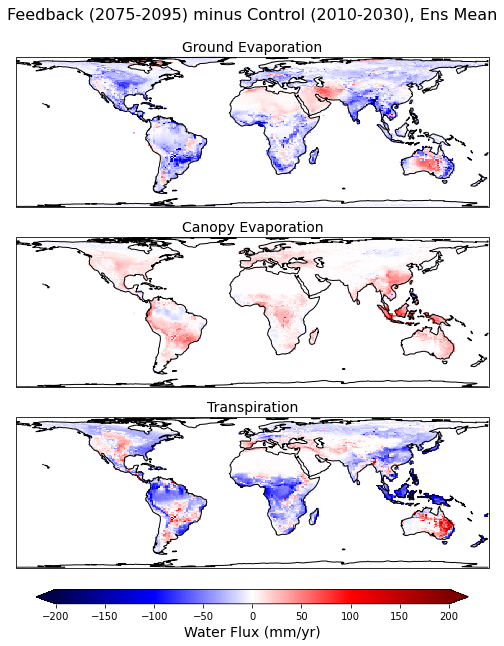

In [103]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})

# discrete colormap
#cmap=plt.cm.get_cmap('BrBG', 14)
vmin=-200
vmax=200

field, lon = add_cyclic_point(QSOIL_diffs, coord=QSOIL_diffs.lon)
lat = QSOIL_diffs.lat   
cf = axs[0].pcolormesh(lon, lat, field*86400*365, cmap='seismic',transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
axs[0].coastlines()
axs[0].set_global()  
axs[0].set_title('Ground Evaporation', fontsize=14)
#fig.colorbar(cf, ax=axs[0], orientation='vertical', extend='both')

field, lon = add_cyclic_point(QVEGE_diffs, coord=QVEGE_diffs.lon)
lat = QVEGE_diffs.lat   
cf = axs[1].pcolormesh(lon, lat, field*86400*365, cmap='seismic',transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
axs[1].coastlines()
axs[1].set_global()
axs[1].set_title('Canopy Evaporation', fontsize=14)
#fig.colorbar(cf, ax=axs[1], orientation='vertical', extend='both')

field, lon = add_cyclic_point(QVEGT_diffs, coord=QVEGT_diffs.lon)
lat = QVEGT_diffs.lat   
cf = axs[2].pcolormesh(lon, lat, field*86400*365, cmap='seismic',transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
axs[2].coastlines()
axs[2].set_global()
axs[2].set_title('Transpiration', fontsize=14)
#fig.colorbar(cf, ax=axs[2], orientation='vertical', extend='both')

fig.suptitle(diffname+', Ens Mean', fontsize=16)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.91, left=0.1, right=0.9, wspace=0.02, hspace=0.2)

# Colorbar settings - coordinate left and width to be centered; order is xmin, ymin, width, height
cb_ax = fig.add_axes([0.35, 0.15, 0.3, 0.02])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('Water Flux (mm/yr)', fontsize=14);

#plt.savefig("QSOIL_QVEGE_QVEGT_diffs.png")

### Revise the above figure to match other extremes figures

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/regionmask/core/plot.py:151: FutureWarning: 'proj' has been renamed to 'projection'
  warnings.warn("'proj' has been renamed to 'projection'", FutureWarning)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/regionmask/core/plot.py:12: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  coords += [np.asarray(p.exterior)[:, :2]] + [
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geome

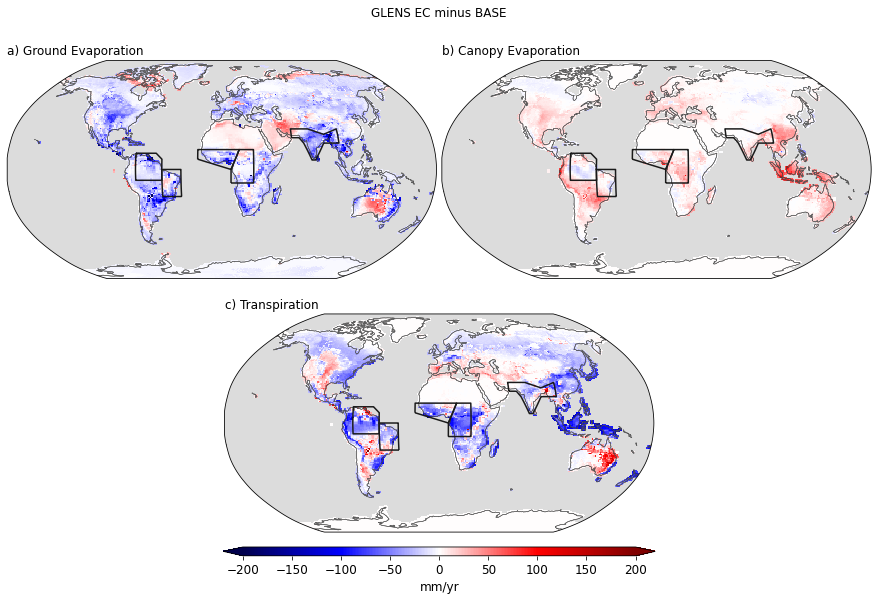

In [26]:
# range
vmin = -200
vmax = 200

# colormap
cmap = plt.get_cmap('seismic')

# define ar6 regions
regions = ["NSA", "NES", "WAF", "CAF", "SAS"]
ar6 = regionmask.defined_regions.ar6.land

fig = plt.figure(figsize=(12, 7))

grid = gridspec.GridSpec(nrows=4, ncols=4, figure=fig, left=0., right=1., top=1., bottom=0.,
                         wspace=0.025, hspace=0.025,)

proj = ccrs.PlateCarree()

# getting the right grid indices to properly center the third plot in the second row
# see: https://stackoverflow.com/questions/34799488/how-to-manually-position-one-subplot-graph-in-matplotlib-pyplot
ax1 = fig.add_subplot(grid[:2,:2], projection=ccrs.Robinson())
ax2 = fig.add_subplot(grid[:2,2:], projection=ccrs.Robinson())
ax3 = fig.add_subplot(grid[2:4,1:3], projection=ccrs.Robinson())

ax1.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax2.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')
ax3.add_feature(cartopy.feature.OCEAN, zorder=0, facecolor='gainsboro', edgecolor='none')

ax1.coastlines(linewidth=0.5, zorder=1)
ax2.coastlines(linewidth=0.5, zorder=1)
ax3.coastlines(linewidth=0.5, zorder=1)

# add regional boxes
ar6[regions].plot(ax=ax1, proj=proj, add_label=False)
ar6[regions].plot(ax=ax2, proj=proj, add_label=False)
ar6[regions].plot(ax=ax3, proj=proj, add_label=False)

# -------- plots

# QSOIL
field, lon = add_cyclic_point(QSOIL_diffs*86400*365, coord=QSOIL_diffs.lon) # convert from mm/s to mm/yr
lat = QSOIL_diffs.lat
pl_a = ax1.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)
ax1.set_title('a) Ground Evaporation', fontsize=12, loc='left')

# QVEGE
field, lon = add_cyclic_point(QVEGE_diffs*86400*365, coord=QVEGE_diffs.lon)
lat = QVEGE_diffs.lat 
pl_b = ax2.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)
ax2.set_title('b) Canopy Evaporation', fontsize=12, loc='left')

# QVEGT
field, lon = add_cyclic_point(QVEGT_diffs*86400*365, coord=QVEGT_diffs.lon)
lat = QVEGT_diffs.lat 
pl_c = ax3.pcolormesh(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=proj)
ax3.set_title('c) Transpiration', fontsize=12, loc='left')

# ----------- colorbar

cax = fig.add_axes([0.25, -0.015, 0.5, 0.0175])
cbar_ = plt.colorbar(pl_a, orientation='horizontal', cax=cax, extend='both')
cbar_.set_label(label = 'mm/yr', size=12)
#cbar_.set_ticks([-6,-4,-2,0,2,4,6])
cbar_.ax.tick_params(labelsize=12)

# ----------- map gridlines
"""
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, lw=0.75, color='gray', alpha=0.5, ls='--')
gl.xlocator = mticker.FixedLocator([-90, 0, 90]); gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60]); gl.ylabel_style = {'size': 10, 'color': 'gray'}
gl.top_labels = False; gl.left_labels = False; gl.bottom_labels = False; gl.right_labels = False

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, lw=0.75, color='gray', alpha=0.5, ls='--')
gl.xlocator = mticker.FixedLocator([-90, 0, 90]); gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60]); gl.ylabel_style = {'size': 10, 'color': 'gray'}
gl.top_labels = False; gl.left_labels = False; gl.bottom_labels = False; gl.right_labels = False

gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, lw=0.75, color='gray', alpha=0.5, ls='--')
gl.xlocator = mticker.FixedLocator([-90, 0, 90]); gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60]); gl.ylabel_style = {'size': 10, 'color': 'gray'}
gl.top_labels = False; gl.left_labels = False; gl.bottom_labels = False; gl.right_labels = False

gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, lw=0.75, color='gray', alpha=0.5, ls='--')
gl.xlocator = mticker.FixedLocator([-90, 0, 90]); gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60]); gl.ylabel_style = {'size': 10, 'color': 'gray'}
gl.top_labels = False; gl.left_labels = False; gl.bottom_labels = False; gl.right_labels = False
"""
# ----------- titles

fig.suptitle("GLENS EC minus BASE", fontsize=12, y=1.075);

# geocat way of setting subplot titles (would need to import/change environment)
#gvutil.set_titles_and_labels(ax1, lefttitle="a) Latent Heat Flux", lefttitlefontsize=12)
#gvutil.set_titles_and_labels(ax2, lefttitle="b) 10cm Soil Moisture", lefttitlefontsize=12)
#gvutil.set_titles_and_labels(ax3, lefttitle="c) Leaf Area Index", lefttitlefontsize=12)
#gvutil.set_titles_and_labels(ax4, lefttitle="d) Gross Primary Production", lefttitlefontsize=12)

# ----------- save fig

#plt.savefig('../figures/QSOIL_QVEGE_QVEGT_diffs_revised.png', bbox_inches='tight')
#plt.savefig('../figures/QSOIL_QVEGE_QVEGT_diffs_revised_greyocn.png', bbox_inches='tight')
plt.savefig('../figures/QSOIL_QVEGE_QVEGT_diffs_revised_greyocn_regions.png', bbox_inches='tight')
plt.show()
plt.close()

# -------- 